# Monthly Prediction of Marine Biodiversity Observation Intensity  
## Using Sea Surface Temperature (Indonesia)

Marine biodiversity monitoring data are often temporally incomplete due to limited field surveys, logistical constraints, and reporting delays.  
As a result, certain months may have sparse or missing biological observations.

This project demonstrates how environmental data — specifically sea surface temperature (SST) — can be used to estimate the intensity of recorded marine biodiversity observations at a **monthly resolution**.

The objective is not to predict true species abundance, but to explore how environmental signals can support estimation and planning in data-limited marine monitoring scenarios.

## Dataset Description

This project uses two independent datasets that are commonly encountered in marine data analysis workflows.

### 1. Marine Biodiversity Observations (OBIS)
- Source: Ocean Biodiversity Information System (OBIS)
- Data type: Species occurrence records
- Nature of data: Presence-only observations influenced by sampling effort
- Field used in this analysis:
  - `eventDate`

The OBIS dataset is aggregated monthly to represent **observation intensity**, not population size.

### 2. Sea Surface Temperature (SST)
- Source: NOAA / regional SST product
- Data type: Environmental time series
- Field used:
  - `time`
  - `sst`

SST values are aggregated into monthly mean values to align with biodiversity observations.


## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## LOAD OBIS DATA

## Processing Biodiversity Observations

OBIS data represent recorded observations and are influenced by sampling effort.
For this analysis, records are aggregated annually to reflect observation intensity.

In [2]:
obis = pd.read_csv(
    "/kaggle/input/marine-biodiversity-indonesia-2015-2025/Occurrence.tsv",
    sep="\t",
    low_memory=False
)

print(obis.shape)
obis.head()

(9855, 282)


,dataset_id,id,acceptedNameUsage,acceptedNameUsageID,accessRights,aphiaid,areas,associatedMedia,associatedOccurrences,associatedOrganisms,...,vernacularName,verticalDatum,vitality,waterBody,wrims,year,originalScientificName,flags,dropped,absence
0,10b213e6-a9c4-459e-a40c-ef9edc461b97,04d57084-43c8-4f48-95d2-35ffcfa1daa3,NaN,NaN,http://www.vertnet.org/resources/norms.html,204972,"[115, 31908]",NaN,NaN,NaN,...,NaN,NaN,NaN,Indo-Malayan Region,NaN,2015.0,Cirrhilabrus,[],False,False
1,11bdbc14-d56d-49f2-933a-6c879aa8e806,8af799a2-db28-4661-b4a3-855caaf50723,NaN,NaN,NaN,137206,[115],NaN,NaN,NaN,...,Green sea turtle,NaN,NaN,NaN,NaN,2017.0,Chelonia mydas,"[NO_DEPTH, ON_LAND]",False,False
2,303d794f-52c8-42a2-b77d-c1fe164855db,6183f4c2-2a43-4c5e-bbe6-ac24fbf34262,NaN,NaN,NaN,146537,"[115, 31910]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,NaN,Cyanobacteria,[],False,False
3,303d794f-52c8-42a2-b77d-c1fe164855db,fd518f94-8fff-4a8c-8023-b36a0ac7a552,NaN,NaN,NaN,1,"[115, 31910]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Biota,[],False,False
4,303d794f-52c8-42a2-b77d-c1fe164855db,fd44ca56-bc07-4ce2-aab6-893117a74f42,NaN,NaN,NaN,148899,"[115, 31910]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,NaN,Bacillariophyceae,[],False,False


## Monthly Aggregation of Biodiversity Observations

To quantify biodiversity observation intensity, individual OBIS records are aggregated by year and month.

The resulting monthly count reflects how frequently marine organisms were recorded during each period.

In [3]:
obis["eventDate"] = pd.to_datetime(obis["eventDate"], errors="coerce")

obis["year"] = obis["eventDate"].dt.year
obis["month"] = obis["eventDate"].dt.month

monthly_obis = (
    obis
    .groupby(["year", "month"])
    .size()
    .reset_index(name="occurrence_count")
)

monthly_obis.head()

,year,month,occurrence_count
0,2015.0,1.0,6
1,2015.0,2.0,11
2,2015.0,3.0,11
3,2015.0,4.0,4
4,2015.0,5.0,4


## LOAD SST DATA

## Processing Sea Surface Temperature Data

Sea surface temperature is aggregated into annual mean values to align with biodiversity observation trends.

In [4]:
sst = pd.read_csv("/kaggle/input/marine-biodiversity-indonesia-2015-2025/SST_2015-2025 (Indonesia).csv")
sst.head()


/tmp/ipykernel_184/991758313.py:1: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  sst = pd.read_csv("/kaggle/input/marine-biodiversity-indonesia-2015-2025/SST_2015-2025 (Indonesia).csv")


,time,latitude,longitude,sst
0,UTC,degrees_north,degrees_east,degree_C
1,2015-01-01T00:00:00Z,-12.875,94.125,27.956451
2,2015-01-01T00:00:00Z,-12.875,94.375,27.978064
3,2015-01-01T00:00:00Z,-12.875,94.625,28.012903
4,2015-01-01T00:00:00Z,-12.875,94.875,28.067741


In [5]:
sst = sst.drop(sst.index[0])
sst.head()

,time,latitude,longitude,sst
1,2015-01-01T00:00:00Z,-12.875,94.125,27.956451
2,2015-01-01T00:00:00Z,-12.875,94.375,27.978064
3,2015-01-01T00:00:00Z,-12.875,94.625,28.012903
4,2015-01-01T00:00:00Z,-12.875,94.875,28.067741
5,2015-01-01T00:00:00Z,-12.875,95.125,28.076773


In [6]:
sst["latitude"] = pd.to_numeric(sst["latitude"], errors='coerce')
sst["longitude"] = pd.to_numeric(sst["longitude"], errors='coerce')
sst["sst"] = pd.to_numeric(sst["sst"], errors='coerce')

sst = sst[
    (sst["latitude"] >= -11) &
    (sst["latitude"] <= 6) &
    (sst["longitude"] >= 95) &
    (sst["longitude"] <= 141)
]

sst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1639072 entries, 1549 to 1946593
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1639072 non-null  object 
 1   latitude   1639072 non-null  float64
 2   longitude  1639072 non-null  float64
 3   sst        1293363 non-null  float64
dtypes: float64(3), object(1)
memory usage: 62.5+ MB


## Monthly Aggregation of Sea Surface Temperature

SST values are averaged at a monthly scale to match the temporal resolution of biodiversity observations.

In [7]:
sst["time"] = pd.to_datetime(sst["time"], errors="coerce")

sst["year"] = sst["time"].dt.year
sst["month"] = sst["time"].dt.month

monthly_sst = (
    sst
    .groupby(["year", "month"])["sst"]
    .mean()
    .reset_index(name="monthly_mean_sst")
)

monthly_sst.head()

,year,month,monthly_mean_sst
0,2015,1,28.945783
1,2015,2,28.819287
2,2015,3,29.031449
3,2015,4,29.550902
4,2015,5,29.506278


## MERGE DATASETS

## Integrating Biodiversity and Environmental Data

The two datasets are merged using year and month as common temporal keys.

In [8]:
monthly_data = pd.merge(
    monthly_obis,
    monthly_sst,
    on=["year", "month"],
    how="inner"
)

monthly_data.head()

,year,month,occurrence_count,monthly_mean_sst
0,2015.0,1.0,6,28.945783
1,2015.0,2.0,11,28.819287
2,2015.0,3.0,11,29.031449
3,2015.0,4.0,4,29.550902
4,2015.0,5.0,4,29.506278


# Machine Learning Model

## Train–Test Split (Temporal)

To avoid data leakage, the dataset is split chronologically.
Earlier years are used for training, while more recent months are reserved for testing.

In [9]:
train_data = monthly_data[monthly_data["year"] < 2024]
test_data  = monthly_data[monthly_data["year"] >= 2024]

X_train = train_data[["monthly_mean_sst"]]
y_train = train_data["occurrence_count"]

X_test = test_data[["monthly_mean_sst"]]
y_test = test_data["occurrence_count"]

## Model Training

A linear regression model is used to estimate monthly biodiversity observation intensity based on SST.

The model prioritizes interpretability over complexity.

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Prediction and Model Evaluation

Predictions are generated for the test period, and model performance is evaluated using RMSE.

In [11]:
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
rmse

41.08469585615628

## Observed vs Predicted Monthly Observation Intensity

The following visualization compares observed biodiversity records with SST-based estimates.

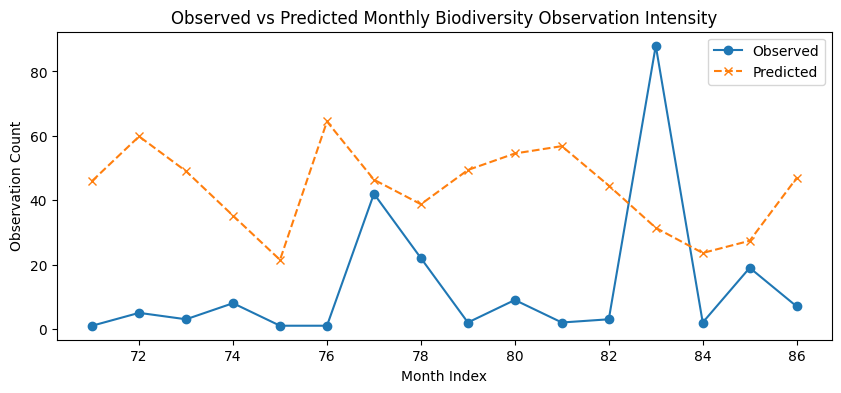

In [12]:
plt.figure(figsize=(10,4))

plt.plot(
    test_data.index,
    y_test,
    marker="o",
    label="Observed"
)

plt.plot(
    test_data.index,
    y_pred,
    linestyle="--",
    marker="x",
    label="Predicted"
)

plt.xlabel("Month Index")
plt.ylabel("Observation Count")
plt.title("Observed vs Predicted Monthly Biodiversity Observation Intensity")
plt.legend()
plt.show()

## Interpretation

The model indicates that monthly sea surface temperature contains useful signal for estimating biodiversity observation intensity.

However, predicted values represent patterns in recording activity rather than true ecological abundance.
The results should be interpreted as exploratory support for data gap analysis and survey planning.

## Limitations

- Biodiversity observation counts are influenced by sampling effort and reporting bias.
- SST alone cannot explain complex ecological processes.
- The model is intended for estimation and exploratory analysis, not ecological forecasting.
- Results depend on temporal coverage and data quality.

## Conclusion

This project demonstrates a practical application of machine learning to support estimation of marine biodiversity observation intensity using environmental data.

By integrating biological and environmental datasets at a monthly resolution, the analysis reflects real-world challenges in marine monitoring and data-limited scenarios.